In [3]:
import os
import math
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from dataloader.NTURGBDwithFlowLoaderVal import NTURGBDwithFlowLoader, NTURGBDwithFlowLoaderValidation
from tqdm import tqdm

import json
import collections
import h5py

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import skimage.measure
from skimage.transform import resize

import time
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F


In [2]:
class arg():
    def __init__(self):
        self.target_length = 6
        self.visual_transform = None
        self.batch_size = 1
        self.num_workers = 24
        self.ntu_dir = '/scratch/salik/NTU_top_dir_h5/'

args = arg()

margs = {}
margs['json_file'] = os.path.join(args.ntu_dir, 'ntu_rgbd_videonames.min.json')
margs['label_file'] = os.path.join(args.ntu_dir, 'ntu_rgbd_action_labels.txt')
margs['flow_h5_dir'] = os.path.join(args.ntu_dir, 'Extracted3DFlowH5')
margs['rgb_h5_dir'] = os.path.join(args.ntu_dir, 'nturgb+d_rgb_pngs_320x240_lanczos_h5')
margs['depth_h5_dir'] = os.path.join(args.ntu_dir, 'MaskedDepthMaps_320x240_h5')
margs['flow_sm_h5_dir'] = os.path.join(args.ntu_dir, 'Extracted3DFlowH5_smm')


train_loader, train_dataset = NTURGBDwithFlowLoader(
    json_file=margs['json_file'], 
    label_file=margs['label_file'], 
    rgb_h5_dir=margs['rgb_h5_dir'], 
    depth_h5_dir=margs['depth_h5_dir'], 
    flow_h5_dir=margs['flow_h5_dir'],
    flow_sm_h5_dir=margs['flow_sm_h5_dir'],
    #flow_h5_dir_sm=margs['flow_h5_dir_sm'], 
    target_length=args.target_length, 
    subset='train', 
    visual_transform=args.visual_transform, 
    batch_size=args.batch_size, 
    shuffle=True, 
    num_workers=args.num_workers, 
    pin_memory=True
    ) 

=======actual videonames=========== 40320
========total data========== 506727
NTURGBDwithFlow is initialized. (Subset: train, Length: 506727)


In [3]:
ntu_dir = '/scratch/salik/NTU_top_dir_h5/'
flow_h5_dir = os.path.join(ntu_dir, 'Extracted3DFlowH5')

json_file = os.path.join(ntu_dir, 'ntu_rgbd_videonames.min.json')

with open(json_file, 'r', encoding='utf-8') as fp:
  meta = json.load(fp, object_pairs_hook=collections.OrderedDict)

videonames = meta['videonames']
videonames = sorted(videonames)

frames = []
#for k in meta['framelength']:
    #frames.append(meta['framelength'][k])
    #if k == videoname:
        #print(meta['framelength'][k])

        
print(len(videonames))

56880


In [4]:

videoname = videonames[20200]
#frame = frames[0]
frame_indices = [0,1,2,3,4,5]

flow_h5_path = os.path.join(flow_h5_dir, videoname + '_3dflow.h5')
flow_h5 = h5py.File(flow_h5_path, 'r', libver='latest', swmr=True)
flows = []
for f in flow_h5['flow'][frame_indices]:
  #flow = cropND(f, (self.side_size // self.patch_size, self.side_size // self.patch_size, 3)) # centercrop
  #flow = skimage.measure.block_reduce(f, (8,8), np.mean)
  flow = torch.from_numpy(f)
  flow = resize(f, (28, 28))
  ##### Resize operation using interpolate on tensors
  #flow = np.transpose(flow, (2, 0, 1))
  #flow = F.interpolate(flow, 224 // 8)
  #flow = np.transpose(flow, (2, 0, 1))
  #flow = F.interpolate(flow, 224 // 8)
  #flow = np.transpose(flow, (1,0,2))
  ######################
  flow = np.transpose(flow, (2,0,1))
  #flow = flow * 1000 # multiply 50 to "keep proper scale" according to [1]
  flows.append(torch.FloatTensor(flow))
flows = torch.stack(flows)

In [5]:
print(flows.shape)
print(videoname)

torch.Size([6, 3, 28, 28])
S007C003P001R001A041


In [6]:
flowss = []
for x,image in enumerate(flows):
    #print(image.shape)
    flowss.append( image.numpy().transpose(1, 2, 0)*10000 )
    #print(image.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.7244444


(6, 28, 28, 3)

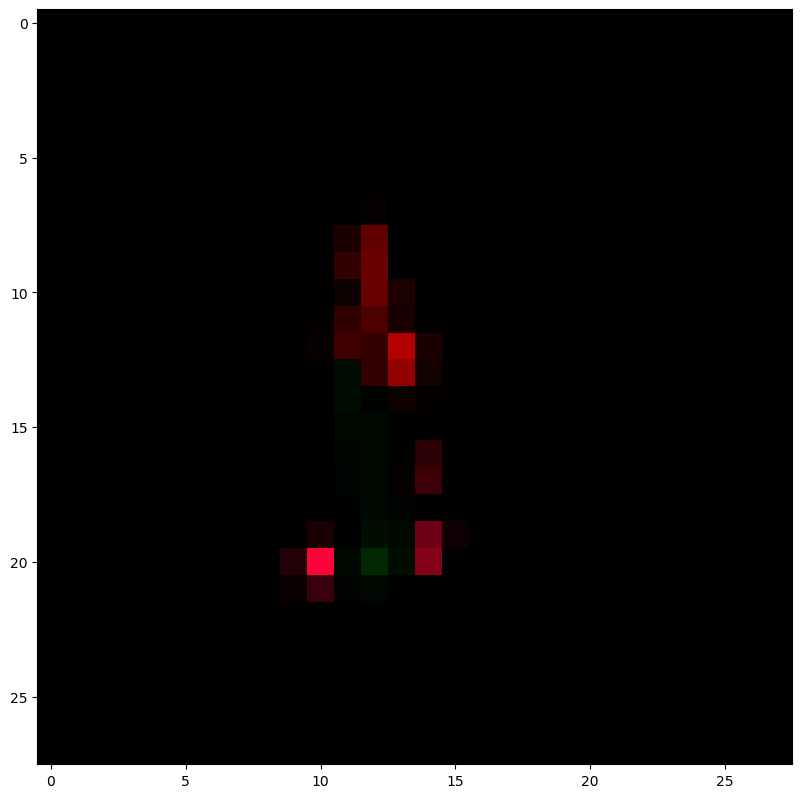

In [7]:
#print(np.shape(depths))

figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 10), dpi=100)

axes.imshow(flowss[1],cmap='gray')

print(flowss[0].min())

np.shape(flowss)

In [24]:

class arguments():
    def __init__(self):
        self.output_dir = "/scratch/salik/NTU_top_dir_h5/Extracted3DFlowH5_smm/"
        self.videoname_json_path = "ntu_rgbd_videonames.json"
        self.top_dir = "/scratch/salik/NTU_top_dir_h5/Extracted3DFlowH5/"
        self.patch_size = 8
        self.num_worker = 32
        
args = arguments()


In [4]:
def bin_ndarray(ndarray, new_shape, operation='sum'):
  """
  Bins an ndarray in all axes based on the target shape, by summing or
      averaging.

  Number of output dimensions must match number of input dimensions and 
      new axes must divide old ones.

  Example
  -------
  >>> m = np.arange(0,100,1).reshape((10,10))
  >>> n = bin_ndarray(m, new_shape=(5,5), operation='mean')
  >>> print(n)

  [[ 22  30  38  46  54]
   [102 110 118 126 134]
   [182 190 198 206 214]
   [262 270 278 286 294]
   [342 350 358 366 374]]

  """
  operation = operation.lower()
  if not operation in ['sum', 'mean']:
    raise ValueError("Operation not supported.")
  if ndarray.ndim != len(new_shape):
    raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                         new_shape))
  compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                ndarray.shape)]
  flattened = [l for p in compression_pairs for l in p]
  ndarray = ndarray.reshape(flattened)
  for i in range(len(new_shape)):
    op = getattr(ndarray, operation)
    ndarray = op(-1*(i+1))
  return ndarray

In [18]:
arr = np.arange(0,16,1).reshape((4,4))
print(arr)
arr2 = np.arange(16,32,1).reshape((4,4))
print(arr2)
arr4 = np.arange(32,48,1).reshape((4,4))
print(arr4)

arr3 = np.empty([3,4,4])
print(arr3.shape)
arr3[0]=arr
arr3[1]=arr2
arr3[2]=arr4
print(arr3)



[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]]
[[32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]]
(3, 4, 4)
[[[ 0.  1.  2.  3.]
  [ 4.  5.  6.  7.]
  [ 8.  9. 10. 11.]
  [12. 13. 14. 15.]]

 [[16. 17. 18. 19.]
  [20. 21. 22. 23.]
  [24. 25. 26. 27.]
  [28. 29. 30. 31.]]

 [[32. 33. 34. 35.]
  [36. 37. 38. 39.]
  [40. 41. 42. 43.]
  [44. 45. 46. 47.]]]


In [20]:
n = bin_ndarray(arr3, new_shape=(4,4,3), operation='mean')
print(n)



ValueError: cannot reshape array of size 48 into shape (4,0,4,1,3,1)

In [13]:
def asMinutes(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def timeSince(since):
  now = time.time()
  s = now - since
  return '%s' % (asMinutes(s))   
    

In [14]:
def flow_text_to_h5(args, videoname_ind, videoname, length):
  start_time = time.time()
  input_height = 224
  input_width = 224
  
  flow_h5_path = os.path.join(args.top_dir,videoname+ '_3dflow.h5')

  target_height = input_height
  target_width = input_width
  if args.patch_size > 0:
    target_height = input_height // args.patch_size
    target_width = input_width // args.patch_size
  
  #flow_h5_path = os.path.join(flow_h5_dir, videoname + '_3dflow.h5')
  flow_h5 = h5py.File(flow_h5_path, 'r', libver='latest', swmr=True)
  flows = []
  for f in flow_h5['flow']:

    flows.append(f)
  #flows = torch.stack(flows)
  flows = np.array(flows)
  outfile_path = os.path.join(args.output_dir, videoname + '_3dflow.h5')
  outfile = h5py.File(outfile_path, 'w')
  dset = outfile.create_dataset('flow', 
    (np.shape(flows)[0],target_height,target_width,3), 
    maxshape=(np.shape(flows)[0],target_height,target_width,3), 
    chunks=True, dtype='f4')

  for i,frames in enumerate(flows):
    flow = bin_ndarray(frames, 
    new_shape=(target_height,target_width,3), 
    operation='mean'
    )
    dset[i,:] = flow
    

  outfile.close()
  #print('{}/{}. converting pngs of {} to h5 done...took {}'.format(
  #  videoname_ind+1, length, videoname, timeSince(start_time)) )

In [26]:

length = len(videonames)


if args.num_worker < 1:
    for ind, videoname in enumerate(tqdm(videonames)):
      flow_text_to_h5(args, ind, videoname, length)
else:
    from joblib import Parallel, delayed
    Parallel(n_jobs=args.num_worker)(
      delayed(flow_text_to_h5)(args, ind, videoname, length) for ind, videoname in enumerate(tqdm(videonames))
      )



100%|██████████| 56880/56880 [1:20:44<00:00, 11.74it/s]


In [8]:
sample = train_dataset.__getitem__(1530)
rgb = sample ['rgbs']
depth = sample ['depths']
depthother = sample ['otherview_depths']
depthother2 = sample ['otherview2_depths']
flow = sample ['flows']
flowActual = sample['flowsActual']
flowother = sample['otherview_flows']
flowother2 = sample['otherview2_flows']

print("flow=\t\t",flow.shape)
print("flowActual=\t",flowActual.shape)
print("flowother=\t",flowother.shape)
print("flowother2=\t",flowother2.shape)

flow=		 torch.Size([6, 3, 28, 28])
flowActual=	 torch.Size([6, 224, 3, 224])
flowother=	 torch.Size([6, 3, 28, 28])
flowother2=	 torch.Size([6, 3, 28, 28])


In [13]:
images = []
depths = []
depthso = []
depthso2 = []
flows = []
flowso = []
flowso2 = []
flowsActual = []
for x,image in enumerate(rgb):
    images.append( cv2.cvtColor(image.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB) )
    #print(image.shape)
for x,image in enumerate(depth):
    #print(image.shape)
    depths.append( np.squeeze(image.numpy(),axis=0))
    #print(image.shape)
for x,image in enumerate(depthother):
    #print(image.shape)
    depthso.append( np.squeeze(image.numpy(),axis=0))
    #print(image.shape)
for x,image in enumerate(depthother2):
    #print(image.shape)
    depthso2.append( np.squeeze(image.numpy(),axis=0))
    #print(image.shape)
for x,image in enumerate(flowother):
    #print(image.shape)
    flowso.append( image.numpy().transpose(1, 2, 0)*100 )
    #print(image.shape)
for x,image in enumerate(flowother2):
    #print(image.shape)
    flowso2.append( image.numpy().transpose(1, 2, 0)*100 )
    #print(image.shape)
for x,image in enumerate(flow):
    #print(image.shape)
    flows.append( image.numpy().transpose(1, 2, 0)*100 )
    print(image.shape)
    
for x,image in enumerate(flowActual):
    #print(image.shape)
    '''    image2 = np.transpose(image, (0, 2, 1))
    image2 = F.interpolate(image2, 28)
    image2 = np.transpose(image2, (0, 2, 1))
    image2 = F.interpolate(image2,28)'''
    #image2 = resize(image, (3,28, 28))
    #flowsActual.append( image2.transpose(1, 2, 0)*10000 )
    #print(image2.shape)
    flowsActual.append( image.numpy().transpose(1, 2, 0)*100 )
    #print(image.shape)

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-13.720663
-38.440594


(6, 28, 28, 3)

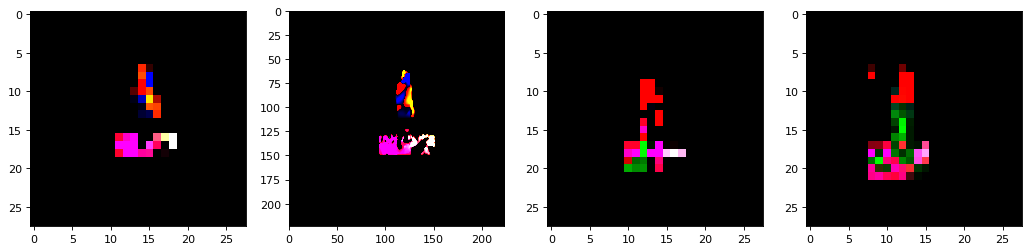

In [14]:
#print(np.shape(depths))

figure, axes = plt.subplots(nrows=1, ncols=4,figsize=(16, 10), dpi=80)

axes[0].imshow(flows[1],cmap='gray')
axes[1].imshow(flowsActual[1],cmap='gray')
axes[2].imshow(flowso[1],cmap='gray')
axes[3].imshow(flowso2[1],cmap='gray')

print(flows[0].min())
print(flowsActual[0].min())

np.shape(flows)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

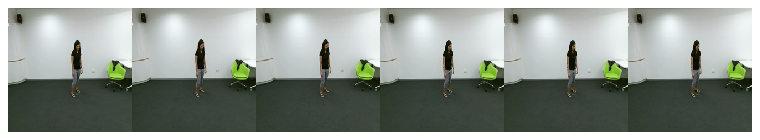

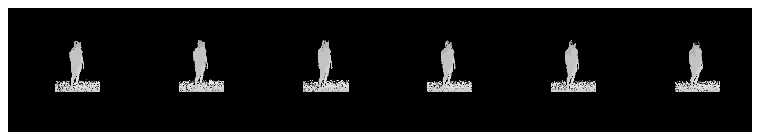

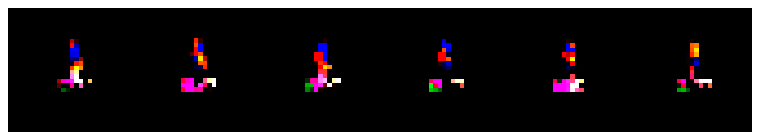

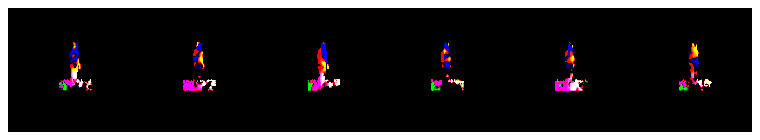

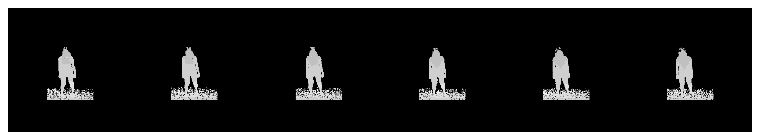

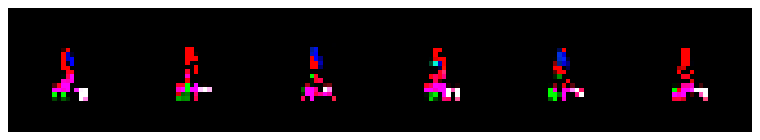

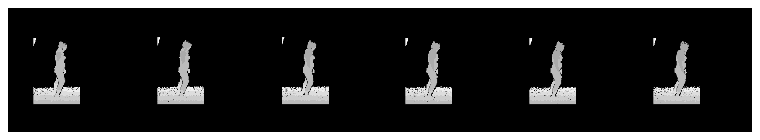

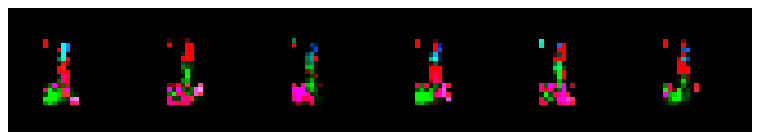

In [15]:

def plot_figures(images,target_length=6):
    import numpy as np
    fig, axs = plt.subplots(1, 6, sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(12, 10), dpi=80)
    (ax1, ax2 , ax3,ax4,ax5,ax6) = axs
    if not np.shape(images)[-1] == 3:
        ax1.imshow(images[0],cmap='gray')
        ax2.imshow(images[1],cmap='gray')
        ax3.imshow(images[2],cmap='gray')
        ax4.imshow(images[3],cmap='gray')
        ax5.imshow(images[4],cmap='gray')
        ax6.imshow(images[5],cmap='gray')
    else:
        ax1.imshow(images[0])
        ax2.imshow(images[1])
        ax3.imshow(images[2])
        ax4.imshow(images[3])
        ax5.imshow(images[4])
        ax6.imshow(images[5])
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    return 
plot_figures(images)
plot_figures(depths)
plot_figures(flows)
plot_figures(flowsActual)
plot_figures(depthso)
plot_figures(flowso)
plot_figures(depthso2)
plot_figures(flowso2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

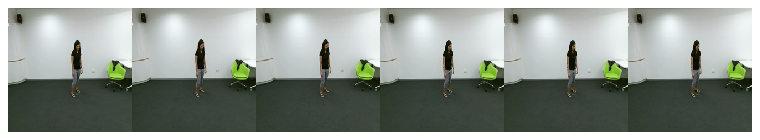

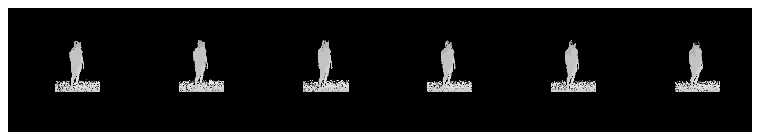

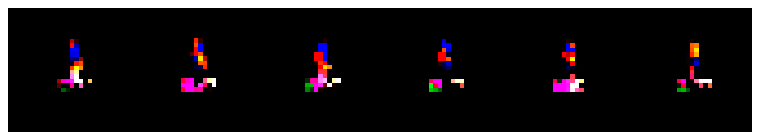

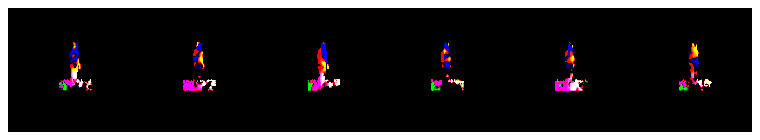

In [17]:
target_length=6
def plot_figures(images,target_length):
    import numpy as np
    fig, axs = plt.subplots(1, 6, sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(12, 10), dpi=80)
    (ax1, ax2 , ax3,ax4,ax5,ax6) = axs
    if not np.shape(images)[-1] == 3:
        ax1.imshow(images[0],cmap='gray')
        ax2.imshow(images[1],cmap='gray')
        ax3.imshow(images[2],cmap='gray')
        ax4.imshow(images[3],cmap='gray')
        ax5.imshow(images[4],cmap='gray')
        ax6.imshow(images[5],cmap='gray')
    else:
        ax1.imshow(images[0])
        ax2.imshow(images[1])
        ax3.imshow(images[2])
        ax4.imshow(images[3])
        ax5.imshow(images[4])
        ax6.imshow(images[5])
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    ax6.axis('off')
    return 
plot_figures(images,target_length)
plot_figures(depths,target_length)
plot_figures(flows,target_length)
plot_figures(flowsActual,target_length)

In [18]:
count = 0
for x in range(2):
    sample = get_sample(x,videonames_sequences,rgb_transform)
    flow = sample ['flows']
    #print(flow.shape)
    for f in flow:
        count = count +1
        if count % 100 == 0:
            print(count)
        if not f.max() == 0. :
            print(f.max())


    
print(count)    

NameError: name 'get_sample' is not defined

In [1]:
import os
import math
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from dataloader.NTURGBDwithFlowLoaderVal import NTURGBDwithFlowLoader, NTURGBDwithFlowLoaderValidation
from tqdm import tqdm

In [2]:


class arg():
    def __init__(self):
        self.target_length = 6
        self.visual_transform = None
        self.batch_size = 16
        self.num_workers = 20
        self.ntu_dir = '/scratch/salik/NTU_top_dir_h5/'

args = arg()

margs = {}
margs['json_file'] = os.path.join(args.ntu_dir, 'ntu_rgbd_videonames.min.json')
margs['label_file'] = os.path.join(args.ntu_dir, 'ntu_rgbd_action_labels.txt')
margs['flow_h5_dir'] = os.path.join(args.ntu_dir, 'Extracted3DFlowH5')
margs['flow_sm_h5_dir'] = os.path.join(args.ntu_dir, 'Extracted3DFlowH5_smm')
margs['rgb_h5_dir'] = os.path.join(args.ntu_dir, 'nturgb+d_rgb_pngs_320x240_lanczos_h5')
margs['depth_h5_dir'] = os.path.join(args.ntu_dir, 'MaskedDepthMaps_320x240_h5')


train_loader, train_dataset = NTURGBDwithFlowLoader(
    json_file=margs['json_file'], 
    label_file=margs['label_file'], 
    rgb_h5_dir=margs['rgb_h5_dir'], 
    depth_h5_dir=margs['depth_h5_dir'], 
    flow_h5_dir=margs['flow_h5_dir'], 
    flow_sm_h5_dir=margs['flow_sm_h5_dir'], 
    target_length=args.target_length, 
    subset='train', 
    visual_transform=args.visual_transform, 
    batch_size=args.batch_size, 
    shuffle=False, 
    num_workers=args.num_workers, 
    pin_memory=True
    ) 

min_actual = math.inf
min_flow = math.inf
min_other = math.inf
min_other2 = math.inf
#count = 0
for batch_ind, sample in enumerate(tqdm(train_loader)):
    #print("Actual=",sample['flowsActual'].shape)
    if sample['flowsActual'].min() < min_actual:
        #print("Actual min=",(sample['flowsActual'].min() ) )
        min_actual = sample['flowsActual'].min()
    #print(sample['flows'].shape)
    if sample['flows'].min() < min_flow:
        #print("flows min=",(sample['flows'].min() ) )
        min_flow = sample['flows'].min()
    #print(sample['otherview_flows'].shape)
    if sample['otherview_flows'].min() < min_other:
        #print("otherview_flows min=",(sample['otherview_flows'].min() ) )
        min_other = sample['otherview_flows'].min()
    #print(sample['otherview2_flows'].shape)
    if sample['otherview2_flows'].min() < min_other2:
        #print("otherview2_flows min=",(sample['otherview2_flows'].min() ) )
        min_other2 = sample['otherview2_flows'].min()
    #if batch_ind % 1000 == 0:
        #print("data=",batch_ind,"/",506727)
    #print(batch_ind)
    #count +=1


  0%|          | 0/31671 [00:00<?, ?it/s]

=======actual videonames=========== 40320
========total data========== 506727
NTURGBDwithFlow is initialized. (Subset: train, Length: 506727)


100%|██████████| 31671/31671 [1:33:45<00:00,  5.63it/s]  


In [3]:
print("Actual min=",(sample['flowsActual'].min() ) )
print("flows min=",(sample['flows'].min() ) )
print("otherview_flows min=",(sample['otherview_flows'].min() ) )
print("otherview2_flows min=",(sample['otherview2_flows'].min() ) )

Actual min= tensor(-1.8453)
flows min= tensor(-1.4796)
otherview_flows min= tensor(-0.3413)
otherview2_flows min= tensor(-0.5551)


In [3]:
print("Actual min=",(sample['flowsActual'].min() ) )
print("flows min=",(sample['flows'].min() ) )
print("otherview_flows min=",(sample['otherview_flows'].min() ) )
print("otherview2_flows min=",(sample['otherview2_flows'].min() ) )

Actual min= tensor(-0.2799)
flows min= tensor(-0.0799)
otherview_flows min= tensor(-0.0278)
otherview2_flows min= tensor(-0.0234)


In [4]:
print("Actual min=",(sample['flowsActual'].min() ) )
print("flows min=",(sample['flows'].min() ) )
print("otherview_flows min=",(sample['otherview_flows'].min() ) )
print("otherview2_flows min=",(sample['otherview2_flows'].min() ) )

Actual min= tensor(-3.1465)
flows min= tensor(-1.1980)
otherview_flows min= tensor(-0.8043)
otherview2_flows min= tensor(-1.1193)


In [6]:
print("Actual min=",(sample['flowsActual'].min() ) )
print("flows min=",(sample['flows'].min() ) )
print("otherview_flows min=",(sample['otherview_flows'].min() ) )
print("otherview2_flows min=",(sample['otherview2_flows'].min() ) )

Actual min= tensor(-3.1465)
flows min= tensor(-1.1980)
otherview_flows min= tensor(-0.8043)
otherview2_flows min= tensor(-1.1193)


In [3]:
print("Actual min=",(sample['flowsActual'].min() ) )
print("flows min=",(sample['flows'].min() ) )
print("otherview_flows min=",(sample['otherview_flows'].min() ) )
print("otherview2_flows min=",(sample['otherview2_flows'].min() ) )

Actual min= tensor(-0.1573)
flows min= tensor(-0.0599)
otherview_flows min= tensor(-0.0402)
otherview2_flows min= tensor(-0.0560)


In [8]:
sample = train_dataset.__getitem__(28130)

In [9]:
rgb = sample ['rgbs']
depth = sample ['depths']
flow = sample ['flows']
flowActual = sample['flowsActual']

In [20]:

images = []
depths = []
flows = []
flowsActual = []
for x,image in enumerate(rgb):
    #print(image.shape)
    images.append( cv2.cvtColor(image.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB) )
for x,image in enumerate(depth):
    #print(image.shape)
    depths.append( np.squeeze(image.numpy(),axis=0))
    
for x,image in enumerate(flow):
    #print(image.shape)
    flows.append( image.numpy().transpose(1, 2, 0)*10000 )
    
for x,image in enumerate(flowActual):
    #print(image.shape)
    '''    image2 = np.transpose(image, (0, 2, 1))
    image2 = F.interpolate(image2, 28)
    image2 = np.transpose(image2, (0, 2, 1))
    image2 = F.interpolate(image2,28)'''
    #image2 = resize(image, (3,28, 28))
    #flowsActual.append( image2.transpose(1, 2, 0)*10000 )
    #print(image2.shape)
    flowsActual.append( image.numpy().transpose(1, 2, 0)*100 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-28.452318


(6, 224, 224, 3)

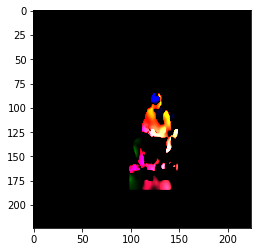

In [23]:
#print(np.shape(depths))

plt.imshow(flowsActual[1],cmap='gray')


print(flowsActual[0].min())

np.shape(flowsActual)